### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
import statsmodels.api as sm
from scipy import stats
import requests
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### Getting the data from the website named :alphavantage

In [2]:
url = 'https://www.alphavantage.co/query?function=BRENT&interval=daily&apikey=G47FZC6JH4IKPIFO'
r = requests.get(url)
data = r.json()

In [3]:
df = pd.DataFrame(data)
df

,name,interval,unit,data
0,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '2023-08-07', 'value': '86.47'}"
1,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '2023-08-04', 'value': '87.38'}"
2,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '2023-08-03', 'value': '86.19'}"
3,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '2023-08-02', 'value': '84.01'}"
4,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '2023-08-01', 'value': '85.34'}"
...,...,...,...,...
9444,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '1987-05-26', 'value': '18.63'}"
9445,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '1987-05-25', 'value': '18.60'}"
9446,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '1987-05-22', 'value': '18.55'}"
9447,Crude Oil Prices Brent,daily,dollars per barrel,"{'date': '1987-05-21', 'value': '18.45'}"


### Extraxting only the data column from whole dataset

In [4]:
df2 = df[['data']]

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9449 entries, 0 to 9448
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    9449 non-null   object
dtypes: object(1)
memory usage: 73.9+ KB


### Modifiying the data into suitable form

In [6]:
# Function to extract the values from the 'data' column
def extract_values(row):
    value = row['value'].replace(',', '.')
    try:
        return row['date'], float(value)
    except ValueError:
        return row['date'], None  # Return None for invalid values

# Applying the function to the 'data' column with apply and zip
df2['date'], df2['value'] = zip(*df2['data'].apply(extract_values))

# Dropping the original 'data' column
df2.drop(columns=['data'], inplace=True)

# Printing the resulting DataFrame
print(df2)


            date  value
0     2023-08-07  86.47
1     2023-08-04  87.38
2     2023-08-03  86.19
3     2023-08-02  84.01
4     2023-08-01  85.34
...          ...    ...
9444  1987-05-26  18.63
9445  1987-05-25  18.60
9446  1987-05-22  18.55
9447  1987-05-21  18.45
9448  1987-05-20  18.63

[9449 rows x 2 columns]


C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_21704\2818618087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'], df2['value'] = zip(*df2['data'].apply(extract_values))
C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_21704\2818618087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'], df2['value'] = zip(*df2['data'].apply(extract_values))
C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_21704\2818618087.py:13: SettingWithCopyWarning: 
A value is trying to be set on a c

In [7]:
df2.sample(10)

,date,value
3017,2012-01-12,112.97
4768,2005-04-27,51.29
3767,2009-02-26,45.15
5977,2000-09-07,37.43
1144,2019-03-19,67.13
7871,1993-06-04,18.25
4479,2006-06-06,68.25
7641,1994-04-22,16.28
6142,2000-01-20,26.26
3175,2011-06-06,115.40


### Converting the date column into date-time format and using it as index.

In [8]:
df2["date"] = pd.to_datetime(df2.date)


C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_21704\3783625677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["date"] = pd.to_datetime(df2.date)


In [9]:
df2.head()

,date,value
0,2023-08-07,86.47
1,2023-08-04,87.38
2,2023-08-03,86.19
3,2023-08-02,84.01
4,2023-08-01,85.34


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9449 entries, 0 to 9448
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9449 non-null   datetime64[ns]
 1   value   9191 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 147.8 KB


In [11]:
df2.shape

(9449, 2)

### Checking the Null values. There are 258 NA values.Which is 2.73% of data

In [12]:
df2.isna().sum()/9439*100

date     0.00000
value    2.73334
dtype: float64

### Filling the NA values

In [13]:
df2['value']=df2['value'].fillna(method ='bfill')

C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_21704\3752313881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['value']=df2['value'].fillna(method ='bfill')


In [14]:
print(df2.isna().sum())
print(df2.shape)

date     0
value    0
dtype: int64
(9449, 2)


### Checking for duplicated values.

In [15]:
df2.duplicated().sum()

0

In [16]:
df2.describe()

,date,value
count,9449,9449.000000
mean,2005-06-27 14:23:56.342470144,49.155899
min,1987-05-20 00:00:00,9.100000
25%,1996-06-07 00:00:00,19.150000
50%,2005-06-28 00:00:00,40.800000
75%,2014-07-17 00:00:00,72.050000
max,2023-08-07 00:00:00,143.950000
std,NaN,32.956536


In [17]:
df2 = df2.set_index('date')

- #### The average price of the crude oil in it's entire history is 49 dollar
- #### The range is 9 dollar to 143.95 dollar with the standard deviation of 32.84 dollar.

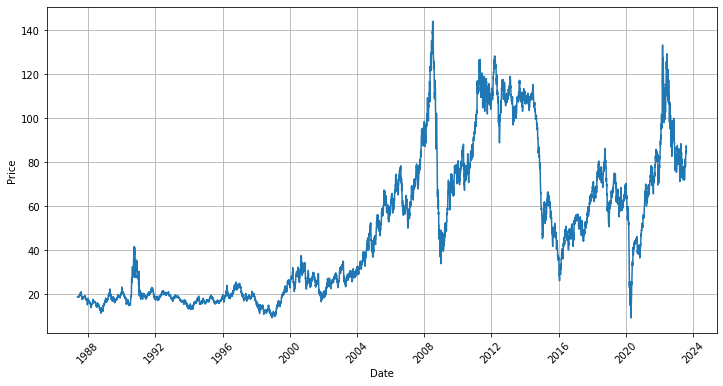

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2['value'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)

### There are some sharp drops - 
1. In 2008 Because of recession 
2. In 2016 because of some investors funding issue
3. In 2020 because of Covid-19.

### Creating and plotting the 200 day's Moving Average to know the trend of data

In [19]:
ma200 = df2.value.rolling(200).mean()
ma200

date
2023-08-07         NaN
2023-08-04         NaN
2023-08-03         NaN
2023-08-02         NaN
2023-08-01         NaN
                ...   
1987-05-26    18.04770
1987-05-25    18.06705
1987-05-22    18.08655
1987-05-21    18.10455
1987-05-20    18.12095
Name: value, Length: 9449, dtype: float64

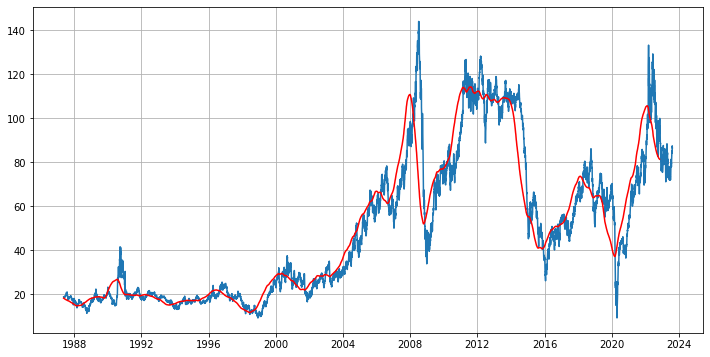

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df2.value)
plt.plot(ma200,'r')
plt.grid(True)

### In its earlier stage it follows the up-trend but after 2008 it becomes volatile.

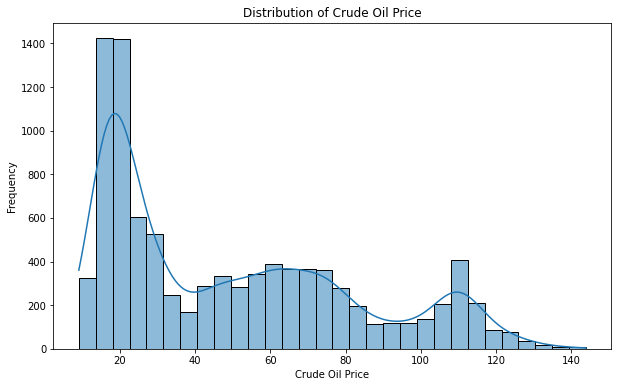

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df2['value'], bins=30, kde=True)
plt.xlabel('Crude Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Crude Oil Price')
plt.show()

<Axes: >

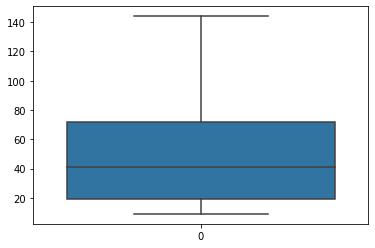

In [22]:
sns.boxplot(df2['value'])

In [23]:
df2['Year'] = pd.DatetimeIndex(df2.index).year
df2['Month'] = pd.DatetimeIndex(df2.index).month

In [24]:
df2.head()

,value,Year,Month
date,,,
2023-08-07,86.47,2023,8
2023-08-04,87.38,2023,8
2023-08-03,86.19,2023,8
2023-08-02,84.01,2023,8
2023-08-01,85.34,2023,8


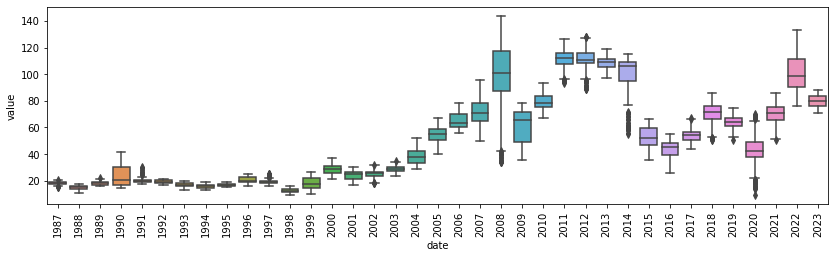

In [25]:
plt.figure(figsize=(14, 8))
plt.subplot(211)
sns.boxplot(x=df2.index.year, y=df2['value'], data=df2)
plt.xticks(rotation=90)
plt.show()

In [26]:
Q1 = df2['value'].quantile(0.20)
Q3 = df2['value'].quantile(0.80)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
df2['value']=np.where(df2['value']>upper_whisker,upper_whisker,np.where(df2['value']<lower_whisker,lower_whisker,df2['value']))

### ACF/Autocorrelation plot

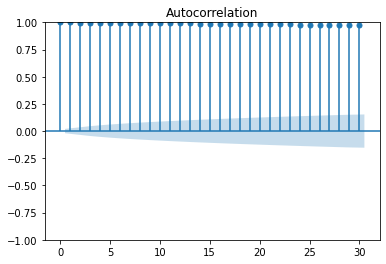

In [27]:
# Autocorrelation Funcation(ACF)
plot_acf(df2.value,lags = 30)
plt.show()

### Lag Plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

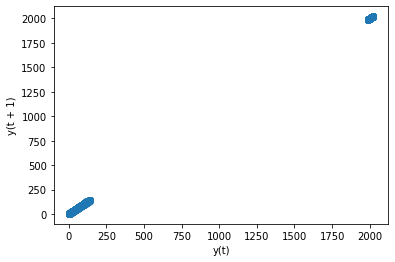

In [28]:
lag_plot(df2)

In [29]:
df2['log_Price']=np.log(df2['value'])

In [30]:
df2

,value,Year,Month,log_Price
date,,,,
2023-08-07,86.47,2023,8,4.459798
2023-08-04,87.38,2023,8,4.470266
2023-08-03,86.19,2023,8,4.456554
2023-08-02,84.01,2023,8,4.430936
2023-08-01,85.34,2023,8,4.446643
...,...,...,...,...
1987-05-26,18.63,1987,5,2.924773
1987-05-25,18.60,1987,5,2.923162
1987-05-22,18.55,1987,5,2.920470


In [31]:
t = np.arange(1,9450)
df2['t']=t

In [32]:
t_squared=np.array(t*t)
df2['t_squared']=t_squared

In [33]:
df2.head()

,value,Year,Month,log_Price,t,t_squared
date,,,,,,
2023-08-07,86.47,2023,8,4.459798,1,1
2023-08-04,87.38,2023,8,4.470266,2,4
2023-08-03,86.19,2023,8,4.456554,3,9
2023-08-02,84.01,2023,8,4.430936,4,16
2023-08-01,85.34,2023,8,4.446643,5,25


In [34]:
df2.sort_index(ascending=True, inplace=True)

In [35]:
#Train Test Split in the ratio of 80:20
train=df2.head(7560)
test=df2.tail(1889)

In [36]:
train

,value,Year,Month,log_Price,t,t_squared
date,,,,,,
1987-05-20,18.63,1987,5,2.924773,9449,89283601
1987-05-21,18.45,1987,5,2.915064,9448,89264704
1987-05-22,18.55,1987,5,2.920470,9447,89245809
1987-05-25,18.60,1987,5,2.923162,9446,89226916
1987-05-26,18.63,1987,5,2.924773,9445,89208025
...,...,...,...,...,...,...
2016-05-04,43.08,2016,5,3.763059,1894,3587236
2016-05-05,44.39,2016,5,3.793014,1893,3583449
2016-05-06,44.60,2016,5,3.797734,1892,3579664


In [37]:
# Linear Model
Linear_model=smf.ols('value~t', data=train).fit( )    #y~x
pred_linear=pd.Series(Linear_model.predict(test['t']))   #predicting for test
rmse_linear = np.sqrt(np.mean((np.array(test['value'])-np.array(pred_linear))**2))    #sqrt of mean(y act - y pred)^2
rmse_linear

results = pd.DataFrame({'Method':['Linear method'], 'RMSE': [rmse_linear]})
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825


In [38]:
#Exponential Model similiar to Linear but insted of Yt we use log(Yt)
#SAME LIKE LINEAR BUT IN PLACE OF Yt WE USE LOG(Yt)
Exp=smf.ols('log_Price~t', data=train).fit( )                                   #log(y)~x
pred_Exp=pd.Series(Exp.predict(test['t']))   #predicting for test
rmse_Exp = np.sqrt(np.mean((np.array(test['value'])-np.array(np.exp(pred_Exp)))**2))    #sqrt of mean(y act - y pred)^2
rmse_Exp
tempResults = pd.DataFrame({'Method':['Exponential Model'], 'RMSE': [rmse_Exp] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093


In [39]:
# Quadratic here we are creating two independent variables

Quad=smf.ols('value~t+t_squared', data=train).fit( )

pred_Quad=pd.Series(Quad.predict(test[['t', 't_squared']]))    #predicting for test
rmse_Quad = np.sqrt(np.mean((np.array(test['value'])-np.array(pred_Quad))**2))    #sqrt of mean(y act - y pred)^2
rmse_Quad

tempResults = pd.DataFrame({'Method':['Quadratic Model'], 'RMSE': [rmse_Exp] })
results = pd.concat([results,tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093


In [40]:
train_len = 7560
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['value'][train_len-1]

In [41]:
#Naive Model
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_naive['naive_forecast'])).round(2)
tempResults = pd.DataFrame({'Method':['Naive Model'], 'RMSE': [rmse] })
results = pd.concat([results,tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093
0,Naive Model,29.930000


In [42]:
y_hat_sma = df2.copy()
ma_window = 365
y_hat_sma['sma_forecast'] = df2['value'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_21704\2163335855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]


In [43]:
# Simple Moving Average
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_sma['sma_forecast'][train_len:])).round(2)
tempResults = pd.DataFrame({'Method':['Simple moving average '], 'RMSE': [rmse] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093
0,Naive Model,29.930000
0,Simple moving average,26.780000


In [44]:
# Double Exponential Smooting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

mod_add12 = ExponentialSmoothing(df2['value'], trend='add')
fitted_model= mod_add12.fit()
df2['DES'] = fitted_model.fittedvalues.shift(-1)
df2.head()

C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


,value,Year,Month,log_Price,t,t_squared,DES
date,,,,,,,
1987-05-20,18.63,1987,5,2.924773,9449,89283601,18.637217
1987-05-21,18.45,1987,5,2.915064,9448,89264704,18.457225
1987-05-22,18.55,1987,5,2.920470,9447,89245809,18.557221
1987-05-25,18.60,1987,5,2.923162,9446,89226916,18.607222
1987-05-26,18.63,1987,5,2.924773,9445,89208025,18.637222


In [45]:
#Triple Exponential Smooting by adding
df2['TESA'] = ExponentialSmoothing(df2['value'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df2.head()

C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


,value,Year,Month,log_Price,t,t_squared,DES,TESA
date,,,,,,,,
1987-05-20,18.63,1987,5,2.924773,9449,89283601,18.637217,18.659036
1987-05-21,18.45,1987,5,2.915064,9448,89264704,18.457225,18.668258
1987-05-22,18.55,1987,5,2.920470,9447,89245809,18.557221,18.468396
1987-05-25,18.60,1987,5,2.923162,9446,89226916,18.607222,18.525363
1987-05-26,18.63,1987,5,2.924773,9445,89208025,18.637222,18.653245


In [46]:
#Triple Exponential Smooting by multiplying
df2['TESM'] = ExponentialSmoothing(df2['value'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df2.head()

C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,value,Year,Month,log_Price,t,t_squared,DES,TESA,TESM
date,,,,,,,,,
1987-05-20,18.63,1987,5,2.924773,9449,89283601,18.637217,18.659036,19.366293
1987-05-21,18.45,1987,5,2.915064,9448,89264704,18.457225,18.668258,18.607937
1987-05-22,18.55,1987,5,2.920470,9447,89245809,18.557221,18.468396,18.345662
1987-05-25,18.60,1987,5,2.923162,9446,89226916,18.607222,18.525363,18.524362
1987-05-26,18.63,1987,5,2.924773,9445,89208025,18.637222,18.653245,18.586236


<Axes: xlabel='date'>

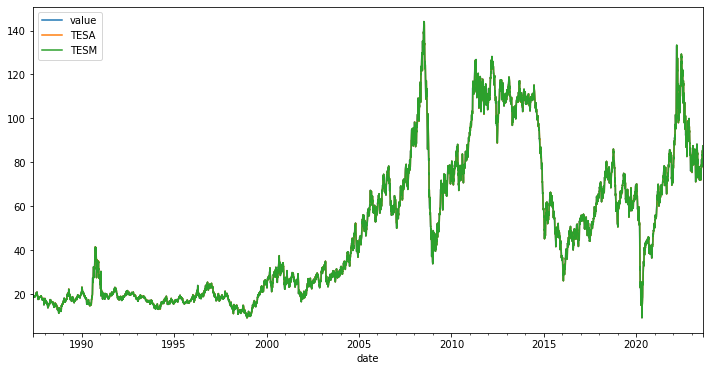

In [47]:
df2[['value','TESA','TESM']].plot(figsize=(12,6))

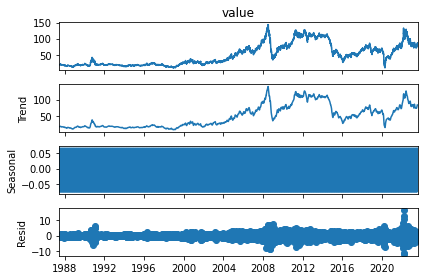

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(df2.value,period=12)
decompose_ts_add.plot()
plt.show()

**ARIMA and SARIMA Model**

In [49]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from scipy.stats import randint

# Define parameter ranges for random search
param_dist = {
    'p': randint(0, 3),
    'd': randint(0, 2),
    'q': randint(0, 3)
}

# Number of random search iterations
n_iter = 10

# Split the data into train and test sets
train_size = int(len(df2) * 0.8)
train_data = df2[:train_size]
test_data = df2[train_size:]

best_mae = float('inf')
best_params = None

# Perform random search
for _ in range(n_iter):
    try:
        random_params = {param: dist.rvs() for param, dist in param_dist.items()}
        order = (random_params['p'], random_params['d'], random_params['q'])

        arima_model = ARIMA(train_data['value'], order=order)
        arima_results = arima_model.fit()

        arima_forecast = arima_results.forecast(steps=len(test_data))
        arima_mae = mean_absolute_error(test_data['value'], arima_forecast)

        if arima_mae < best_mae:
            best_mae = arima_mae
            best_params = order
    except:
        continue

print("Best ARIMA MAE:", best_mae)
print("Best ARIMA Parameters:", best_params)


C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

Best ARIMA MAE: 23.385733825101934
Best ARIMA Parameters: (0, 0, 0)


In [50]:
# You need to specify appropriate values for p, d, and q
order = best_params

In [51]:
# Initialize and fit the ARIMA model
arima_model = ARIMA(train['value'], order=order)
arima_results = arima_model.fit()

C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Rohit Shelar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [52]:
arima_forecast = arima_results.forecast(steps=len(test))

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

arima_mae = mean_absolute_error(test['value'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['value'], arima_forecast))

In [54]:
tempResults = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [arima_rmse] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093
0,Naive Model,29.930000
0,Simple moving average,26.780000
0,ARIMA,29.321587


## LSTM Model

In [55]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df2[['value']])

In [56]:
sequence_length = 10

In [57]:
sequences = []
target = []
for i in range(sequence_length, len(scaled_data)):
    sequences.append(scaled_data[i - sequence_length:i, 0])
    target.append(scaled_data[i, 0])

X = np.array(sequences)
y = np.array(target)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [58]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
236/236 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 2/50
236/236 [==============================] - 1s 4ms/step - loss: 1.8853e-04
Epoch 3/50
236/236 [==============================] - 1s 4ms/step - loss: 1.7383e-04
Epoch 4/50
236/236 [==============================] - 2s 7ms/step - loss: 1.6179e-04
Epoch 5/50
236/236 [==============================] - 1s 5ms/step - loss: 1.6140e-04
Epoch 6/50
236/236 [==============================] - 1s 5ms/step - loss: 1.4930e-04
Epoch 7/50
236/236 [==============================] - 1s 4ms/step - loss: 1.3338e-04
Epoch 8/50
236/236 [==============================] - 1s 4ms/step - loss: 1.3556e-04
Epoch 9/50
236/236 [==============================] - 1s 4ms/step - loss: 1.2423e-04
Epoch 10/50
236/236 [==============================] - 1s 4ms/step - loss: 1.2419e-04
Epoch 11/50
236/236 [==============================] - 1s 3ms/step - loss: 1.1370e-04
Epoch 12/50
236/236 [==============================] - 1s 3ms/step 

In [59]:
# Predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
# Evaluate the LSTM model
lstm_mae = mean_absolute_error(test['value'][-len(lstm_predictions):], lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(test['value'][-len(lstm_predictions):], lstm_predictions))
print("LSTM MAE:", lstm_mae)
print("LSTM RMSE:", lstm_rmse)

59/59 [==============================] - 0s 2ms/step
LSTM MAE: 1.1571205977060026
LSTM RMSE: 1.7385263757198854


In [60]:
tempResults = pd.DataFrame({'Method':['LSTM'], 'RMSE': [lstm_rmse] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093
0,Naive Model,29.930000
0,Simple moving average,26.780000
0,ARIMA,29.321587
0,LSTM,1.738526


## GRU

In [61]:
from tensorflow.keras.layers import GRU

In [62]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df2[['value']])

sequence_length = 10
sequences = []
target = []
for i in range(sequence_length, len(scaled_data)):
    sequences.append(scaled_data[i - sequence_length:i, 0])
    target.append(scaled_data[i, 0])

X = np.array(sequences)
y = np.array(target)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [63]:
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
236/236 [==============================] - 2s 3ms/step - loss: 0.0108
Epoch 2/50
236/236 [==============================] - 1s 3ms/step - loss: 1.2894e-04
Epoch 3/50
236/236 [==============================] - 1s 3ms/step - loss: 1.2079e-04
Epoch 4/50
236/236 [==============================] - 1s 3ms/step - loss: 1.1748e-04
Epoch 5/50
236/236 [==============================] - 1s 3ms/step - loss: 1.1135e-04
Epoch 6/50
236/236 [==============================] - 1s 3ms/step - loss: 1.0450e-04
Epoch 7/50
236/236 [==============================] - 1s 3ms/step - loss: 9.6391e-05
Epoch 8/50
236/236 [==============================] - 1s 3ms/step - loss: 9.4089e-05
Epoch 9/50
236/236 [==============================] - 1s 3ms/step - loss: 9.5477e-05
Epoch 10/50
236/236 [==============================] - 1s 3ms/step - loss: 9.3961e-05
Epoch 11/50
236/236 [==============================] - 1s 3ms/step - loss: 9.0000e-05
Epoch 12/50
236/236 [==============================] - 1s 3ms/step 

In [64]:
#predictions
gru_predictions = model_gru.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

gru_mae = mean_absolute_error(test['value'][-len(gru_predictions):], gru_predictions)
gru_rmse = np.sqrt(mean_squared_error(test['value'][-len(gru_predictions):], gru_predictions))

print("GRU MAE:", gru_mae)
print("GRU RMSE:", gru_rmse)

59/59 [==============================] - 0s 1ms/step
GRU MAE: 1.154966792838048
GRU RMSE: 1.7165361065381732


In [65]:
tempResults = pd.DataFrame({'Method':['GRU'], 'RMSE': [gru_rmse] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093
0,Naive Model,29.930000
0,Simple moving average,26.780000
0,ARIMA,29.321587
0,LSTM,1.738526
0,GRU,1.716536


In [66]:
# Calculate Naive Forecast
data['Naive_Forecast'] = df2['value'].shift(1)
# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
naive_mae = mean_absolute_error(df2['value'].iloc[1:], data['Naive_Forecast'].iloc[1:])
naive_rmse = np.sqrt(mean_squared_error(df2['value'].iloc[1:], data['Naive_Forecast'].iloc[1:]))

print("Naive Forecast MAE:", naive_mae)
print("Naive Forecast RMSE:", naive_rmse)



Naive Forecast MAE: 0.7409123624047418
Naive Forecast RMSE: 1.2105135245944507


In [67]:
tempResults = pd.DataFrame({'Method':['Naive'], 'RMSE': [naive_rmse] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE']]
results

,Method,RMSE
0,Linear method,40.937825
0,Exponential Model,68.004093
0,Quadratic Model,68.004093
0,Naive Model,29.930000
0,Simple moving average,26.780000
0,ARIMA,29.321587
0,LSTM,1.738526
0,GRU,1.716536
0,Naive,1.210514


### Saving the `GRU` Model

In [68]:
import pickle

In [83]:
# Save the entire model to an .h5 file
model_gru.save('trained_model.h5')

In [84]:
# Save the scaler using pickle
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [85]:
# Save only the model weights
model_gru.save_weights('gru_model_weights.h5')

In [89]:
df2. to_csv('dataset.csv', index=True)

- Saving the `LSTM` model

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Save the trained model
model.save('trained_lstm_model.h5')

In [91]:
# Save scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [92]:
# After model training
model.save_weights('lstm_model_weights.h5')